<!--NOTEBOOK_HEADER-->
*This notebook contains course material from [CBE40455](https://jckantor.github.io/CBE40455) by
Jeffrey Kantor (jeff at nd.edu); the content is available [on Github](https://github.com/jckantor/CBE40455.git).
The text is released under the [CC-BY-NC-ND-4.0 license](https://creativecommons.org/licenses/by-nc-nd/4.0/legalcode),
and code is released under the [MIT license](https://opensource.org/licenses/MIT).*

<!--NAVIGATION-->
< [Scenario Analysis for a Plant Expansion](http://nbviewer.jupyter.org/github/jckantor/CBE40455/blob/master/notebooks/06.02-Scenario-Analysis-for-a-Plant-Expansion.ipynb) | [Contents](toc.ipynb) | [Risk Averse Gambler](http://nbviewer.jupyter.org/github/jckantor/CBE40455/blob/master/notebooks/06.04-Risk-Averse-Gambler.ipynb) ><p><a href="https://colab.research.google.com/github/jckantor/CBE40455/blob/master/notebooks/06.03-Risk-Neutral-Gambler.ipynb"><img align="left" src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open in Colab" title="Open in Google Colaboratory"></a><p><a href="https://raw.githubusercontent.com/jckantor/CBE40455/master/notebooks/06.03-Risk-Neutral-Gambler.ipynb"><img align="left" src="https://img.shields.io/badge/Github-Download-blue.svg" alt="Download" title="Download Notebook"></a>

# Risk Neutral Gambler

## Problem Statement

THe risk neutral gambler enters a game with the idea of betting until he or she either reaches a goal $N$ or runs out of money.  Beginning with a stake $x$ and wager $u$, the resulting stake is either $x+u$ with probability $p$, or $x-u$ with probability $q$ (where $p + q \leq 1$.) The wager must be smaller than the stake or any maximum wager established for the game.  The future value of money may be discounted by a factor $a \leq 1$.  

Given an initial stake $x \lt N$, what is the optimal gambling strategy?

## Formulation

This classic problem in Dynamic Programming is discussed, for example, by Richard Sutton and Andrew Barto in their book [_Reinforcement Learning_ (MIT Press, 1998)](http://mitpress.mit.edu/books/reinforcement-learning). The function $V(k,x)$ is the expected value of the game after the $k^{th}$ wager and with a stake $x$. If the gambler reaches the goal of winning a stake $N$ at $k$ then the value of the game is $V(k,N) = N$. If the gambler loses everything, then $V(k,0) = 0$. Otherwise, for $x \lt N$, the Bellman equation for optimality provides the recursion

$$V(k-1,x) = a \max_u  \left[ p V(k,x+u) + q V(k,x-u) \right]$$

where $a$ is the discount factor for future values. The maximization is over the set of possible bets ranging from $0$ to the minimum of $x$, $N-x$, or the bet limit $B$. Note that the state space and set of control actions are finite.

## Solution by Linear Programming

The optimality equation can be solved by well known methods for policy iteration.  Alternatively, as shown, for example, by Sheldon Ross in [_Introduction to Stochastic Dynamic Programming_ (Academic Press, 1983)](http://www.amazon.com/Introduction-Stochastic-Dynamic-Programming-Sheldon/dp/0125984219), an exact solution can 
be found by linear programming. We seek a stationary solution $V[x]$ by minimizing $\sum_{x \in 0..N} V[x]$  subject to 

$$ V[x] \geq a \left( p V[x + u] + q V[x-u]\right) $$

for all feasible bets and all $x$ in $1..N-1$ with boundary conditions $V[0] = 0$ and $V[N] = N$.  The set of optimal wagers $u[x]$ are found by determing the constraints that are active at optimality.  $u[x]$ may have multiple values.

## MathProg Model

In [4]:
%%script glpsol -m /dev/stdin -y output.txt --out output

/* Problem Parameters.  Any of these can be adjusted in a data section.  */

param N default 100, >= 1;               # Goal
param p default 0.25, >= 0, <= 1;        # Winning probability
param q default 1-p, >= 0, <= 1-p;       # Losing probability
param B default N, >= 1, <= N;           # Maximum wager size
param a default 1, >= 0, <= 1;           # Discount factor

/* Set of States */

set X:= 0..N;

/* Sets of possible wagers. These are parameterized by the State */

set U{x in X} := 1..min(B,min(N-x,x));

/* Value function */

var V{X};

/* Exact Linear Program Equivalent of the DP */

minimize OBJ: sum{x in X} V[x] ;

s.t. C1 {x in 1..N-1, u in U[x]}: V[x] >=  a*(p*V[x+u] + q*V[x-u]);
s.t. C2: V[0] = 0;
s.t. C3: V[N] = N;

solve;

table tab1 {x in X} OUT "CSV" "output.csv" : 
    x~Stake, V[x]~ExpectedValue;

printf "               Goal = %4d", N;
printf "\n        Maximum Bet = %4d", B;
printf "\nWinning Probability = %8.3f", p ;
printf "\n Losing Probability = %8.3f", q ;
printf "\n    Discount Factor = %8.3f", a;
printf "\n\n %7s  %10s   %4s\n",'x','V[x]','u[x]: Optimal Wagers';
printf     " %7s  %10s   %4s"  ,'-','----','---------------------';
for {x in X}{
   printf "\n %7d  %10.4f  ",x, V[x];
   printf {u in U[x]: abs(-V[x] + a*(p*V[x+u] + q*V[x-u])) < 0.00001} " %3d",u;
}

end;


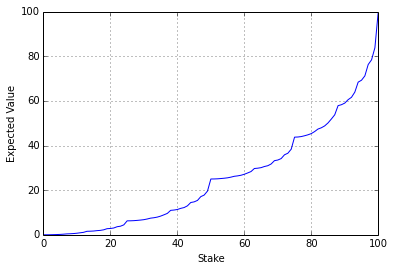

In [10]:
import pandas as pd
df = pd.read_csv('output.csv')
df['ExpectedValue'].plot()
xlabel('Stake')
ylabel('Expected Value')

In [5]:
f = open("output.txt")
print(f.read())
f.close()

               Goal =  100
        Maximum Bet =  100
Winning Probability =    0.250
 Losing Probability =    0.750
    Discount Factor =    1.000

       x        V[x]   u[x]: Optimal Wagers
       -        ----   ---------------------
       0      0.0000  
       1      0.0073     1
       2      0.0291     2
       3      0.0695     3
       4      0.1166     4
       5      0.1771     5
       6      0.2781     6
       7      0.4037     7
       8      0.4663     8
       9      0.5601     9
      10      0.7085    10
      11      0.9041    11
      12      1.1124    12
      13      1.5680    12  13
      14      1.6146    11  14
      15      1.6953    10  15
      16      1.8652     9  16
      17      1.9826     8  17
      18      2.2406     7  18
      19      2.7385     6  19
      20      2.8340     5  20
      21      3.0495     4  21
      22      3.6164     3  22
      23      3.8496     2  23
      24      4.4497     1  24
      25      6.2500    25
      26      6.2

<!--NAVIGATION-->
< [Scenario Analysis for a Plant Expansion](http://nbviewer.jupyter.org/github/jckantor/CBE40455/blob/master/notebooks/06.02-Scenario-Analysis-for-a-Plant-Expansion.ipynb) | [Contents](toc.ipynb) | [Risk Averse Gambler](http://nbviewer.jupyter.org/github/jckantor/CBE40455/blob/master/notebooks/06.04-Risk-Averse-Gambler.ipynb) ><p><a href="https://colab.research.google.com/github/jckantor/CBE40455/blob/master/notebooks/06.03-Risk-Neutral-Gambler.ipynb"><img align="left" src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open in Colab" title="Open in Google Colaboratory"></a><p><a href="https://raw.githubusercontent.com/jckantor/CBE40455/master/notebooks/06.03-Risk-Neutral-Gambler.ipynb"><img align="left" src="https://img.shields.io/badge/Github-Download-blue.svg" alt="Download" title="Download Notebook"></a>